## Подключитесь к базе. Загрузите таблицы sql

In [10]:
!pip install catboost

In [1]:
from sqlalchemy import create_engine
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}

In [3]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string)

## Проведите первичное исследование таблиц

In [15]:
query = """
SELECT * FROM parties
"""


parties = pd.read_sql_query(query, con=engine) 
parties.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


In [16]:
query = """
SELECT * FROM collisions
"""


collisions = pd.read_sql_query(query, con=engine) 
collisions.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [17]:
query = """
SELECT * FROM vehicles
"""


vehicles = pd.read_sql_query(query, con=engine) 
vehicles.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0


In [18]:
query = """
SELECT * FROM case_ids
"""


case_ids = pd.read_sql_query(query, con=engine) 
case_ids.head()

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


Итак, можно сделать вывод, что все таблицы существуют, необходимые признаки так же присутсвутют в таблицах и есть общий ключ для связи таблиц

##  Проведите статистический анализ факторов ДТП

In [19]:
query = """
SELECT  distinct cast(extract(month from collision_date) as int) as month,
count(case_id) over(partition by extract(month from collision_date))
FROM collisions
"""
collisions_per_month = pd.read_sql_query(query, con=engine) 
collisions_per_month = collisions_per_month.set_index(['month'])
collisions_per_month

,count
month,
1,132044
2,128858
3,139581
4,130180
5,130316
6,102594
7,102227
8,104089
9,105159


<AxesSubplot:xlabel='month'>

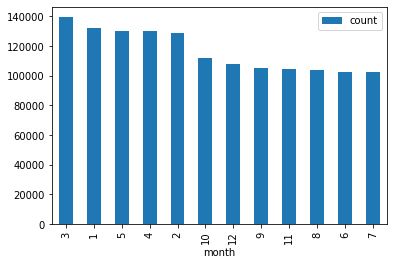

In [20]:
collisions_per_month.sort_values(by='count', ascending=False).plot(kind='bar')

По данному графику можно сказать, что наибольше количество аварий происходит в Марте, Январе, Мае, Апреле и Феврале. Это можно объяснить тем, что в эти месяца погода и осадки могут создавать помехи во время дорожного движения, что может послужить причиной аварии. 

Кроме того, необходимо провести статистический анализ и выявить: 
1. В какое время суток наиболее часто происходят аварии 
2. В какую погоду наиболее часто происходят аварии 
3. Для каждого состояния водителя необходимо определить среднее количество каждого типа аварий 
4. Для каждого состояние трезвости водителя определить наиболее частотную серьезность происшествия
5. Связать погоду и серьезность происшествия
6. Для каждого типа участника происшествия связать освещение

Например, для решения задачи 3 необходимо сделать следующее: 
1. Создать SQL запрос, где в сводной таблице необходимо подсчитать количество каждого типа аварий для каждого состояния водителя
2. Из сводной таблицы взять состояние водителя и среднее количества 
3. На данном наборе данных построить HeatMap
4. Сделать выводы по полученным данным
А для решения задачи 4 нужно: 
1. Сделать SQL запрос, где в сводной таблице необходимо подсчитать частоту серьезности происшествий для каждого состояния трезвости водителя
2. Из сводной таблицы взять состояние трезвости водителя и макисмальное количество для каждого состояния трезвости водителя
3. На данном наборе данных построить HeatMap
4. Сделать выводы по полученным данным

In [21]:
query = """
select distinct extract(month from collision_date)
from collisions
where extract(year from collision_date) = 2012
"""
months = pd.read_sql_query(query, con=engine) 
months

,date_part
0,1.0
1,2.0
2,3.0
3,4.0
4,5.0
5,6.0
6,7.0
7,8.0
8,9.0
9,10.0


           count
date_part       
1.0        32020
2.0        30377
3.0        32498
4.0        29143
5.0        25168
6.0         3062
7.0          390
8.0          622
9.0          510
10.0         304
11.0         253
12.0         200


<AxesSubplot:xlabel='date_part'>

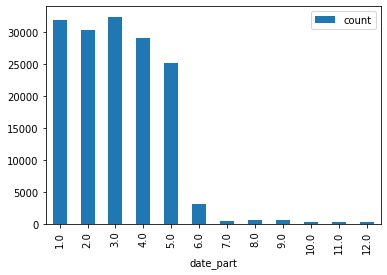

In [22]:
query = """
select distinct extract(month from collision_date), 
    count(*) over(partition by extract(month from collision_date))
from collisions
where extract(year from collision_date) = 2012
"""
bar_months = pd.read_sql_query(query, con=engine) 
bar_months = bar_months.set_index(bar_months.columns[0])
print(bar_months)
bar_months.plot(kind="bar")

## Создайте модель для оценки водительского риска

Для начала подготовим датасет для моделей

In [5]:
query = """
select * 
from collisions c inner join parties p on c.case_id = p.case_id
where PARTY_TYPE like 'car' and COLLISION_DAMAGE not like 'scratch' and extract(year from collision_date) = 2012
"""
data = pd.read_sql_query(query, con=engine) 

In [6]:
data.columns

Index(['case_id', 'county_city_location', 'county_location', 'distance',
       'direction', 'intersection', 'weather_1', 'location_type',
       'collision_damage', 'party_count', 'primary_collision_factor',
       'pcf_violation_category', 'type_of_collision',
       'motor_vehicle_involved_with', 'road_surface', 'road_condition_1',
       'lighting', 'control_device', 'collision_date', 'collision_time', 'id',
       'case_id', 'party_number', 'party_type', 'at_fault',
       'insurance_premium', 'party_sobriety', 'party_drug_physical',
       'cellphone_in_use'],
      dtype='object')

In [7]:
data.shape

(196837, 29)

Итак, необходимо отобрать наиболее важные признаки из датасета

In [8]:
columns = ['county_location', #В каких-то городах траффик более нагруженный
          'distance', #Расстояние до главной дороги может помочь рассчитать вероятность происшествия при составлении маршрута
          'intersection', #Вероятность аварии на перекрестке выше
          'weather_1', #Погода оказывает существенное влияние на вероятность аварии
          'location_type', #Тип дороги влияет на вероятность аварии
          'road_surface', #Состояние дороги тоже важно
          'road_condition_1',
          'lighting', #освещение влияет на вероятность аварии
          'party_type',
           'cellphone_in_use', # использования телефона во время езды влияет на вероятность дтп
          'at_fault'] #целевая переменная

Хотел бы упомянуть такие параметры как 'party_sobriety' и 'party_drug_physical', я считаю, что эти признаки не может определить система при составлении маршрута, а значит и нет смысла их брать в дальнейшем, так как это нереалистично

In [9]:
df = data[columns]
df.head()

,county_location,distance,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,party_type,cellphone_in_use,at_fault
0,orange,162.0,0.0,clear,None,dry,normal,daylight,car,0.0,1
1,los angeles,75.0,0.0,clear,None,dry,normal,daylight,car,0.0,0
2,alameda,2640.0,0.0,clear,highway,dry,normal,dark with no street lights,car,0.0,1
3,tulare,2112.0,0.0,cloudy,None,wet,normal,daylight,car,0.0,0
4,merced,6336.0,0.0,clear,highway,dry,normal,daylight,car,0.0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196837 entries, 0 to 196836
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   county_location   196837 non-null  object 
 1   distance          196837 non-null  float64
 2   intersection      195850 non-null  float64
 3   weather_1         196183 non-null  object 
 4   location_type     87357 non-null   object 
 5   road_surface      195564 non-null  object 
 6   road_condition_1  195694 non-null  object 
 7   lighting          196116 non-null  object 
 8   party_type        196837 non-null  object 
 9   cellphone_in_use  171464 non-null  float64
 10  at_fault          196837 non-null  int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 16.5+ MB


In [11]:
df.isna().sum()

county_location          0
distance                 0
intersection           987
weather_1              654
location_type       109480
road_surface          1273
road_condition_1      1143
lighting               721
party_type               0
cellphone_in_use     25373
at_fault                 0
dtype: int64

In [12]:
cat_features = [col for col in df.columns if df[col].dtypes == 'object']
cat_features.append('cellphone_in_use')
num_features = [col for col in df.columns if col not in cat_features and col != 'at_fault']
print(cat_features)
print(num_features)

['county_location', 'weather_1', 'location_type', 'road_surface', 'road_condition_1', 'lighting', 'party_type', 'cellphone_in_use']
['distance', 'intersection']


In [13]:
features = df.drop('at_fault', axis= 1)
target = df['at_fault']

In [14]:
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=123)

In [15]:
imp = SimpleImputer(strategy='most_frequent')
imp.fit(features_train[num_features])
features_train[num_features] = imp.transform(features_train[num_features])
features_test[num_features] = imp.transform(features_test[num_features])

In [16]:
imp = SimpleImputer(strategy='most_frequent')
imp.fit(features_train[cat_features])
features_train[cat_features] = imp.transform(features_train[cat_features])
features_test[cat_features] = imp.transform(features_test[cat_features])

In [17]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1)
enc.fit(features_train[cat_features])
features_train[cat_features] = enc.transform(features_train[cat_features])
features_test[cat_features] = enc.transform(features_test[cat_features])

In [18]:
scaler = StandardScaler()
scaler.fit(features_train[num_features])
features_train[num_features] = scaler.transform(features_train[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

In [19]:
print(features_train.shape)
features_train.head()

(147627, 10)


,county_location,distance,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,party_type,cellphone_in_use
25554,36.0,0.244430,-0.502281,0.0,0.0,0.0,0.0,1.0,0.0,0.0
68989,18.0,-0.082804,1.990918,1.0,3.0,3.0,4.0,3.0,0.0,0.0
32259,18.0,-0.064211,-0.502281,0.0,0.0,0.0,4.0,3.0,0.0,0.0
110044,48.0,-0.058014,-0.502281,4.0,0.0,3.0,4.0,3.0,0.0,0.0
142696,18.0,-0.064211,-0.502281,0.0,0.0,0.0,4.0,0.0,0.0,0.0


In [20]:
print(features_test.shape)
features_test.head()

(49210, 10)


,county_location,distance,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,party_type,cellphone_in_use
120974,37.0,-0.082804,1.990918,0.0,3.0,0.0,4.0,1.0,0.0,0.0
151825,18.0,-0.080945,-0.502281,0.0,3.0,0.0,4.0,3.0,0.0,0.0
98238,35.0,-0.020828,-0.502281,0.0,0.0,0.0,4.0,3.0,0.0,0.0
150552,18.0,-0.082804,1.990918,0.0,3.0,0.0,4.0,4.0,0.0,0.0
140615,40.0,-0.058014,-0.502281,1.0,0.0,0.0,4.0,3.0,0.0,0.0


In [21]:
print(target_train.shape)
print(target_test.shape)

(147627,)
(49210,)


Теперь перейдем к обучению различных моделей, для оценки качества необходимо использовать метрику F1, так как она дает усредненную информацию между полнотой и точностью предсказания модели, а так же это одна из основных робастных метрик

In [30]:
catboost = CatBoostClassifier(eval_metric='F1')

parameters = {'iterations': [100, 250, 500],
              'depth': [1, 2, 3, 4],
              'l2_leaf_reg': [0.2, 0.5, 1],
              'learning_rate': [0.001, 0.1, 0.5]
}

Следующий код выполняется очень долго

In [31]:
grid_search_result = catboost.grid_search(parameters, 
                                           X=features_train, 
                                           y=target_train, 
                                           plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4094515	test: 0.4015812	best: 0.4015812 (0)	total: 68.9ms	remaining: 6.83s
1:	learn: 0.4094515	test: 0.4015812	best: 0.4015812 (0)	total: 89.7ms	remaining: 4.39s
2:	learn: 0.4094515	test: 0.4015812	best: 0.4015812 (0)	total: 110ms	remaining: 3.56s
3:	learn: 0.4094515	test: 0.4015812	best: 0.4015812 (0)	total: 131ms	remaining: 3.14s
4:	learn: 0.4094515	test: 0.4015812	best: 0.4015812 (0)	total: 151ms	remaining: 2.87s
5:	learn: 0.4094515	test: 0.4015812	best: 0.4015812 (0)	total: 172ms	remaining: 2.69s
6:	learn: 0.4094515	test: 0.4015812	best: 0.4015812 (0)	total: 197ms	remaining: 2.62s
7:	learn: 0.4094515	test: 0.4015812	best: 0.4015812 (0)	total: 222ms	remaining: 2.56s
8:	learn: 0.4094515	test: 0.4015812	best: 0.4015812 (0)	total: 246ms	remaining: 2.49s
9:	learn: 0.4094515	test: 0.4015812	best: 0.4015812 (0)	total: 270ms	remaining: 2.43s
10:	learn: 0.4094515	test: 0.4015812	best: 0.4015812 (0)	total: 293ms	remaining: 2.37s
11:	learn: 0.4094515	test: 0.4015812	best: 0.401581

In [32]:
grid_search_result.get('params')

{'depth': 1, 'iterations': 100, 'learning_rate': 0.1, 'l2_leaf_reg': 0.5}

In [33]:
catboost2 = CatBoostClassifier(depth= 1, l2_leaf_reg =1, iterations = 100, learning_rate = 0.1)
catboost2.fit(features_train, target_train)
predicted = catboost2.predict(features_test)
print(f1_score(target_test, predicted))

0:	learn: 0.6919940	total: 12.1ms	remaining: 1.2s
1:	learn: 0.6914329	total: 23.6ms	remaining: 1.16s
2:	learn: 0.6905880	total: 38.2ms	remaining: 1.24s
3:	learn: 0.6900396	total: 51.4ms	remaining: 1.23s
4:	learn: 0.6895520	total: 63.1ms	remaining: 1.2s
5:	learn: 0.6890760	total: 74.8ms	remaining: 1.17s
6:	learn: 0.6886980	total: 85.7ms	remaining: 1.14s
7:	learn: 0.6882982	total: 97.3ms	remaining: 1.12s
8:	learn: 0.6880368	total: 109ms	remaining: 1.1s
9:	learn: 0.6877356	total: 121ms	remaining: 1.09s
10:	learn: 0.6874035	total: 132ms	remaining: 1.07s
11:	learn: 0.6871546	total: 144ms	remaining: 1.05s
12:	learn: 0.6869294	total: 156ms	remaining: 1.04s
13:	learn: 0.6867172	total: 167ms	remaining: 1.02s
14:	learn: 0.6864910	total: 178ms	remaining: 1.01s
15:	learn: 0.6863075	total: 191ms	remaining: 1s
16:	learn: 0.6861434	total: 203ms	remaining: 992ms
17:	learn: 0.6859520	total: 215ms	remaining: 979ms
18:	learn: 0.6856895	total: 227ms	remaining: 966ms
19:	learn: 0.6854570	total: 239ms	remai

In [34]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [2,4]
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [35]:
rf_Model = RandomForestClassifier()

In [36]:
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = param_grid, cv = 5, verbose=2, n_jobs = 4)

In [ ]:
rf_RandomGrid.fit(features_train, target_train)
rf_RandomGrid.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
rf_params = {'n_estimators': 64,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 4,
 'bootstrap': True}

In [ ]:
random_forest  = RandomForestClassifier(**rf_params)
random_forest.fit(features_train, target_train)
predicted = random_forest.predict(features_test)
print(f1_score(target_test, predicted))

Вместо следующей модели было решено использовать random forest

## Проведите анализ важности факторов ДТП

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    random_forest, features_test, target_test
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    catboost2, features_test, target_test
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
feature_importance = catboost2.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Feature Importance')


Итак, одними из наиболее важнейших признаков является освещение на улице, тип дороги и является пересечение проезжих частей. Эти три признака вносят наибольший вклад в вероятность аварии

Поскольку освещение на улице в момент управления ТС влияет в наибольшее степени на вероятность аварии, что можно предложить следующий функционал для сокращения кол-ва аварий:
1. Создать функцию, которая анализируя период времени будет уведмолять водителя использовать подходящий тип световых сигнало (например дальний или ближний свет фар)
2. Кроме того, можно оборудовать автомобиль светотражающими элементами, чтобы повысить его видимость на дороге для остальных участников движения

In [50]:
query = """
select distinct lighting, 
    at_fault,
    count(*) over(partition by lighting, at_fault)
from collisions c inner join parties p on c.case_id = p.case_id
where extract(year from collision_date) = 2012 and lighting is not Null
"""
pivot = pd.read_sql_query(query, con=engine) 
pivot

,lighting,at_fault,count
0,dark with no street lights,0,8378
1,dark with no street lights,1,11151
2,dark with street lights,0,32484
3,dark with street lights,1,30365
4,dark with street lights not functioning,0,345
5,dark with street lights not functioning,1,339
6,daylight,0,112692
7,daylight,1,96375
8,dusk or dawn,0,5429
9,dusk or dawn,1,4892


<AxesSubplot:xlabel='lighting', ylabel='count'>

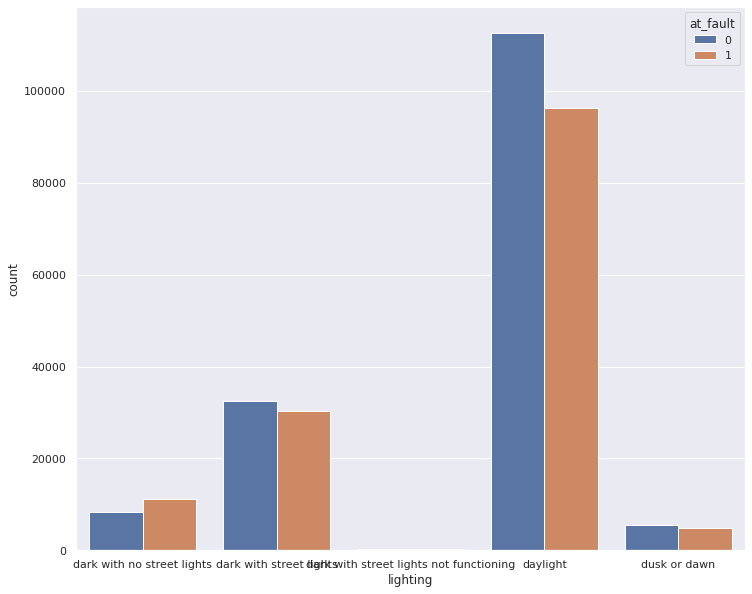

In [54]:
sns.set(rc={'figure.figsize':(12,10)})
sns.barplot(data=pivot,x= "lighting", y= "count",hue="at_fault" )

Итак, приведенный выше график показывает, что больишнство аварий происходят днем и при дневном свете, что вообщем-то не удивительно, поскольку днем больше трафика на дорогах, а значит вероятность аварии больше. А вот второе место почему-то занимает темнота с освещением.

## Выводы

Подводя итоги можно сказать, что обе обученные модели пока дают недостаточно адекватный прогноз для предсказания аварий. Для улучшения качества прогноизрования необходимо заняться feature engineering.
Например, можно собрать данные касательно технического состояния машины, вероятность аварии на данном участке движении и т.д.